# 1. Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn import ensemble
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [3]:
import warnings
warnings.simplefilter('ignore')

# 2. Load Data

Variables have more than 60% of missing were removed (17 Variables). Other missing values are imputed using missRanger() in R.

In [4]:
traindf = pd.read_csv("D:/Github/Risk Modelling/Home_Credit/imputed_application_train.csv", index_col=0)


In [5]:
testdf =  pd.read_csv("D:/Github/Risk Modelling/Home_Credit/imputed_application_test.csv",  index_col=0)

In [6]:
traindf.reset_index(drop=True, inplace=True)

In [7]:
testdf.reset_index(drop=True, inplace=True)

In [8]:
traindf.drop('SK_ID_CURR', axis=1, inplace=True)
#testdf.drop('SK_ID_CURR', axis=1, inplace=True)

Check the shape of Train and Test

In [9]:
traindf.shape

(307511, 104)

In [10]:
testdf.shape

(48744, 104)

Check If Train and Test still have any Missing Values.

In [11]:
traindf.isnull().sum().sum()

0

In [12]:
testdf.isnull().sum().sum()

0

In [13]:
Y_train = traindf['TARGET']
traindf.drop('TARGET', axis=1, inplace=True)

# 3. PreProcessing

## Dimensionality Reduction / Feature Selection

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_numerical = traindf.select_dtypes(include=numerics)


#### Check If Dataset is Imbalance

0    282686
1     24825
Name: TARGET, dtype: int64

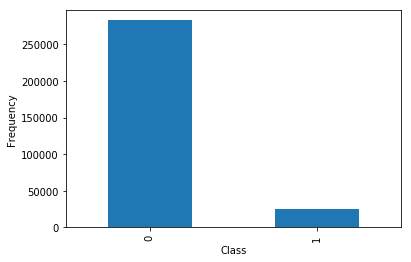

In [15]:
Y_train.value_counts().plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
Y_train.value_counts()

#### Correlation

In [16]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = train_numerical.corr().abs()
# Create a True/False mask and apply it
mask_highcor = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask_highcor)
# List column names of highly correlated features (r > 0.95)
to_drop_corr = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]
to_drop_corr

['AMT_CREDIT',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE']

#### Random Forest for Feature Selection (aka. Variable Importance)

In [16]:
# Fit the random forest model to the training data
rf = ensemble.RandomForestClassifier(random_state=123, n_jobs = -1)
rf.fit(train_numerical, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [18]:
mask_rf = rf.feature_importances_ > 0.1
mask_rf

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

Variable Importance could not provide useful info for this Dataset

#### Low Variance Features (Nearly Zero Variance)

In [19]:
train_numerical_normalized = normalize(train_numerical)

In [20]:
train_numerical_normalized = pd.DataFrame(train_numerical_normalized, columns= train_numerical.columns)    

In [21]:
train_numerical_normalized.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000
mean,7.582951e-07,0.250205,0.680554,0.035602,0.609664,3.457717e-08,-0.026816,0.091443,-0.008487,-0.005062,...,1.232409e-08,6.733024e-10,4.283852e-10,1.058861e-09,1.079334e-08,1.079625e-08,5.945036e-08,4.119176e-07,4.432761e-07,0.000003
std,1.718599e-06,0.154365,0.097869,0.013674,0.089206,3.279435e-08,0.018869,0.223811,0.008987,0.004550,...,1.634263e-07,3.291835e-08,2.220685e-08,5.988198e-08,1.776146e-07,1.982048e-07,4.122528e-07,1.575023e-06,1.303766e-06,0.000005
min,0.000000e+00,0.008285,0.004808,0.000224,0.003885,9.096407e-11,-0.270832,-0.146592,-0.151247,-0.063714,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.137588,0.662169,0.025049,0.580624,1.319427e-08,-0.035122,-0.004022,-0.011445,-0.006821,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.209656,0.701153,0.032916,0.633043,2.476389e-08,-0.021507,-0.001653,-0.005793,-0.003862,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000002
75%,9.049948e-07,0.321186,0.741016,0.041307,0.665516,4.503918e-08,-0.013655,-0.000383,-0.002420,-0.002011,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000004
max,8.554940e-05,0.999981,0.945914,0.088115,0.984382,6.292569e-07,-0.000108,0.980988,0.000000,0.000000,...,5.116118e-06,3.706396e-06,2.970517e-06,5.049317e-06,1.612006e-05,1.732212e-05,2.827764e-05,6.445936e-05,1.731100e-04,0.000093


In [22]:
# Create a VarianceThreshold feature selector
sel =VarianceThreshold(threshold=10**-3)
# Fit the selector to normalized head_df
sel.fit(train_numerical_normalized / train_numerical_normalized.mean())
# Create a boolean mask
mask_lowvar = sel.get_support()

In [23]:
mask_lowvar

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Low Variance could not provide useful info for this Dataset

#### 3-D Mapping T-SNE 

![title](t-sne.png)

##  Transform Variables

#### Convert Categorical Variables into Numerical using OneHotEncoding(OHE) and LabelEncoder

In [17]:
categorical_mask = (traindf.dtypes == object)

In [18]:
categorical_columns = traindf.columns[categorical_mask].tolist()
categorical_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [19]:
Categorical_Level  =traindf[categorical_columns].nunique().sort_values(ascending=False)
Categorical_Level

ORGANIZATION_TYPE             57
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
NAME_EDUCATION_TYPE            5
HOUSETYPE_MODE                 3
CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_REALTY                2
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
dtype: int64

If the Variable has more than 5 levels then It would be applied LabelEncoder, otherwise applied OHE

In [20]:
OHE_List = Categorical_Level[Categorical_Level<=5].index.tolist()
LE_List = Categorical_Level[Categorical_Level>5].index.tolist()

In [21]:
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df_le = traindf[LE_List].apply(lambda x: le.fit_transform(x))

In [22]:
df_ohe = pd.get_dummies(traindf[OHE_List])

#### Train Data after Converting 

In [23]:
traindf.drop(categorical_columns, axis=1, inplace=True)

In [24]:
traindf = pd.concat([traindf,df_ohe, df_le], axis=1)

In [25]:
traindf.drop(to_drop_corr, axis=1, inplace=True)

In [26]:
traindf.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,ORGANIZATION_TYPE,OCCUPATION_TYPE,NAME_INCOME_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,NAME_TYPE_SUITE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS
0,0,202500.0,24700.5,351000.0,0.018801,-9461,-3648.0,-2120,1,1,...,1,0,5,8,7,5,6,6,1,3
1,0,270000.0,35698.5,1129500.0,0.003541,-16765,-1186.0,-291,1,1,...,1,0,39,3,4,0,1,1,1,1
2,0,67500.0,6750.0,135000.0,0.010032,-19046,-4260.0,-2531,1,1,...,0,1,11,8,7,4,1,6,1,3
3,0,135000.0,29686.5,297000.0,0.008019,-19005,-9833.0,-2437,1,1,...,1,0,5,8,7,0,6,6,1,0
4,0,121500.0,21865.5,513000.0,0.028663,-19932,-4311.0,-3458,1,1,...,1,0,37,3,7,0,4,6,1,3


# Model Building

## 1. Xgboost (with Tuning Hyperparameter and remove highly correlated features)

In [49]:
xgbpipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', xgb.XGBClassifier())])

In [51]:
# Create the parameter grid
gbm_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 300, 50),
    'clf__clf_colsample_bytree' : [0.6,0.8,1.0]
}

In [52]:
# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=xgbpipeline, param_distributions=gbm_param_grid, 
                                        n_iter=10, scoring='roc_auc', cv=5,
                                        random_state=123, n_jobs = -2)
 

In [53]:
# Fit the estimator
randomized_roc_auc.fit(traindf,Y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                          

#### Best Estimator of XGB Model

In [54]:
# Compute metrics
print(randomized_roc_auc.best_estimator_)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster=None,
                               clf_colsample_bytree=1.0, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.15000000000000002,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                      

In [55]:
print(randomized_roc_auc.best_score_)

0.7708415079877616


In [56]:
model_xgb_probs = randomized_roc_auc.predict_proba(traindf)


In [57]:
scores = randomized_roc_auc.predict_proba(traindf)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, scores)

roc_auc = roc_auc_score(Y_train, scores)

print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.7870927972427697


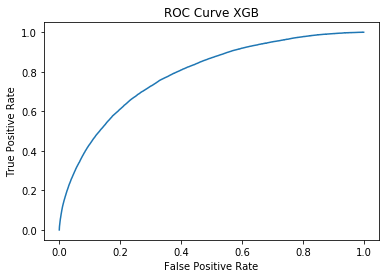

In [58]:
plt.plot(fpr, tpr)
plt.title("ROC Curve XGB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [59]:
predictions = [round(value) for value in scores]
accuracy = accuracy_score(Y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.02%


## Predict for Test Data

In [27]:
testdf.shape

(48744, 104)

In [28]:
SK_ID_CURR_Col = testdf['SK_ID_CURR']

In [29]:
testdf.drop('SK_ID_CURR', axis=1, inplace=True)

#### Transform Test Data

In [30]:
df_ohe_test = pd.get_dummies(testdf[OHE_List])

In [31]:
df_le_test = testdf[LE_List].apply(lambda x: le.fit_transform(x))

In [32]:
testdf.drop(categorical_columns, axis=1, inplace=True)

In [33]:
testdf = pd.concat([testdf, df_ohe_test, df_le_test], axis=1)

In [34]:
testdf.drop(to_drop_corr, axis=1, inplace=True)

In [35]:
testdf.shape

(48744, 93)

In [36]:
test_cols = testdf.columns.tolist()
train_cols = traindf.columns.tolist()

Check if Train and Test have same set of Variables

In [37]:
list(set(train_cols) - set(test_cols))

[]


#### Fit XGB to Test Data

In [84]:
score_test = randomized_roc_auc.predict_proba(testdf)[:,1]

In [85]:
score_test.shape

(48744,)

In [86]:
SK_ID_CURR_Col.shape

(48744,)

In [87]:
submit_df1 = pd.DataFrame({'SK_ID_CURR':SK_ID_CURR_Col, 'TARGET': score_test})

In [88]:
submit_df1.shape

(48744, 2)

In [89]:
submit_df1.to_csv("submit_df_3004.csv",index=False)

The Score of Submission is: 0.74392

## 2. Random Forest

In [37]:
rfpipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier())])

In [38]:
# Create the parameter grid
rf_param_grid = {
    'clf__max_depth': np.arange(2, 20, 2),
    'clf__n_estimators': np.arange(50, 600, 50),
    'clf__min_samples_split' : [2, 5, 10, 15, 20,30],
    'clf__min_samples_leaf' : [1, 2, 5, 10,15] 
    
}

In [39]:
# Perform RandomizedSearchCV
RF_randomized_roc_auc = RandomizedSearchCV(estimator=rfpipeline, param_distributions=rf_param_grid, 
                                        n_iter=10, scoring='roc_auc', cv=5,
                                        random_state=123, n_jobs = -4)
 

In [40]:
# Fit the estimator
RF_randomized_roc_auc.fit(traindf,Y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                     

In [41]:
RF_randomized_roc_auc.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=14, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5,
                                        min_samples_split=15,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
       

In [42]:
print(RF_randomized_roc_auc.best_score_)

0.7579438130871872


In [43]:
model_rf_probs = RF_randomized_roc_auc.predict_proba(traindf)

In [44]:
rf_scores = RF_randomized_roc_auc.predict_proba(traindf)[:,1]

rffpr, rftpr, rfthresholds = roc_curve(Y_train, rf_scores)

roc_auc = roc_auc_score(Y_train, rf_scores)

print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.8946606502053431


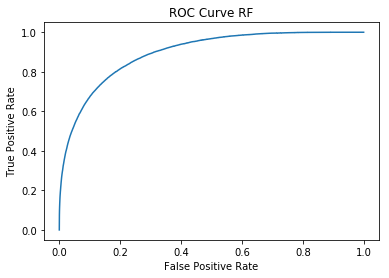

In [45]:
plt.plot(rffpr, rftpr)
plt.title("ROC Curve RF")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [46]:
rf_score_test = RF_randomized_roc_auc.predict_proba(testdf)[:,1]

In [47]:
submit_df_rf = pd.DataFrame({'SK_ID_CURR':SK_ID_CURR_Col, 'TARGET': rf_score_test})

In [48]:
submit_df_rf.shape

(48744, 2)

In [49]:
submit_df_rf.to_csv("submit_df_0105_rf.csv",index=False)

The Score of Submission is: 0.74013

## 3. Adaptive Boosting (AdaBoost)

In [69]:
abpipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', AdaBoostClassifier())])

In [76]:
# Create the parameter grid
ab_param_grid = {

    'clf__n_estimators': np.arange(50, 500, 50),
    'clf__learning_rate': np.arange(0.05, 1, 0.05)
}

In [77]:
# Perform RandomizedSearchCV
AB_randomized_roc_auc = RandomizedSearchCV(estimator=abpipeline, param_distributions=ab_param_grid, 
                                        n_iter=10, scoring='roc_auc', cv=5,
                                        random_state=123, n_jobs = -2)

In [78]:
# Fit the estimator
AB_randomized_roc_auc.fit(traindf,Y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=None,
                                                                 learning_rate=1.0,
                                                                 n_estimators=50,
                                                                 random_state=None))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-2,
                   param_distribut

In [86]:
AB_randomized_roc_auc.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=0.3, n_estimators=450,
                                    random_state=None))],
         verbose=False)

In [79]:
AB_randomized_roc_auc.best_score_

0.7686824052650442

In [80]:
ab_scores = AB_randomized_roc_auc.predict_proba(traindf)[:,1]

abfpr, abtpr, abthresholds = roc_curve(Y_train, ab_scores)

roc_auc = roc_auc_score(Y_train, ab_scores)

print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.7737066896303814


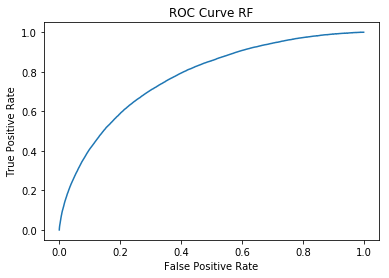

In [81]:
plt.plot(abfpr, abtpr)
plt.title("ROC Curve RF")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [82]:
ab_score_test = RF_randomized_roc_auc.predict_proba(testdf)[:,1]

In [83]:
submit_df_ab = pd.DataFrame({'SK_ID_CURR':SK_ID_CURR_Col, 'TARGET': ab_score_test})

In [84]:
submit_df_ab.shape

(48744, 2)

In [85]:
submit_df_ab.to_csv("submit_df_0105_ab.csv",index=False)

The score of Submission is: 0.74013

## 4. Bagging Decision Tree

In [54]:
bagpipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', BaggingClassifier())])


In [58]:
# Create the parameter grid
bag_param_grid = {
    'clf__max_samples': np.arange(2, 20, 2),
    'clf__n_estimators': np.arange(100, 1000, 100)
    BaggingClassifier
}

In [64]:
# Perform RandomizedSearchCV
Bag_randomized_roc_auc = RandomizedSearchCV(estimator=bagpipeline, param_distributions=bag_param_grid, 
                                        n_iter=10, scoring='roc_auc', cv=5,
                                        random_state=123, n_jobs = -2)

In [65]:
Bag_randomized_roc_auc.fit(traindf,Y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              BaggingClassifier(base_estimator=None,
                                                                bootstrap=True,
                                                                bootstrap_features=False,
                                                                max_features=1.0,
                                                                max_samples=1.0,
                                                                n_estimators=10,
                                                                n_jobs=No

In [66]:
Bag_randomized_roc_auc.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=18, n_estimators=900,
                                   n_jobs=None, oob_score=False,
                                   random_state=None, verbose=0,
                                   warm_start=False))],
         verbose=False)

In [67]:
Bag_randomized_roc_auc.best_score_

0.6706280832845153

## 5. Stacking Model

In [37]:
Scaler = StandardScaler()

In [38]:
scaled_train = Scaler.fit_transform(traindf)

In [39]:
scaled_test = Scaler.fit_transform(testdf)

In [40]:
scaled_traindf = pd.DataFrame(scaled_train, columns = traindf.columns)

In [41]:
scaled_testdf  = pd.DataFrame(scaled_test, columns = testdf.columns)

In [42]:
xgb_stack = xgb.XGBClassifier(max_depth=4, learning_rate=0.15,n_estimators=100,colsample_bytree=1)
rf_stack = RandomForestClassifier(max_depth=14,min_samples_leaf=5,min_samples_split=15,n_estimators=500)
ada_stack = AdaBoostClassifier(learning_rate=0.3, n_estimators=450)
#bagging_stack = BaggingClassifier(max_samples=18, n_estimators=900)

meta_stack = MLPClassifier()


In [43]:
stack_clf = StackingCVClassifier(classifiers = [xgb_stack, rf_stack, ada_stack],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = meta_stack,
                            n_jobs=10)

In [44]:
stack_clf.fit(scaled_traindf,Y_train)

StackingCVClassifier(classifiers=[XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=1, gamma=None,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.15,
                                                max_delta_step=None,
                                                max_depth=4,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=100, n_jobs...
      

In [45]:
classifiers = {"XGB": xgb_stack,
               "RF": rf_stack,
               "AdaBoost": ada_stack}

In [51]:
# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(scaled_traindf, Y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

In [53]:
score = []
for key in classifiers:
    score.append(roc_auc_score(Y_train, classifiers[key].predict_proba(scaled_traindf)[:,1]) )
    

In [56]:
print(score)

[0.7870927972427697, 0.8953406773701612, 0.7737066896303814]


In [57]:
roc_auc_score(Y_train, stack_clf.predict_proba(scaled_traindf)[:,1])

0.812376757079097

#### Tuning Meta-Classifier

In [49]:
stack_params = {
                "meta_classifier__solver": ["sgd", "adam"]
               }


In [51]:

# Initialize GridSearchCV
stack_grid = GridSearchCV(estimator = stack_clf, 
                    param_grid = stack_params, 
                    cv = 3,
                    scoring = "roc_auc",
                    verbose = 10,
                    n_jobs = -4)


In [52]:
# Fit GridSearchCV
stack_grid.fit(scaled_traindf, Y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-4)]: Done   2 out of   6 | elapsed: 62.9min remaining: 125.8min
[Parallel(n_jobs=-4)]: Done   3 out of   6 | elapsed: 63.0min remaining: 63.0min
[Parallel(n_jobs=-4)]: Done   4 out of   6 | elapsed: 63.0min remaining: 31.5min
[Parallel(n_jobs=-4)]: Done   6 out of   6 | elapsed: 63.4min remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   6 out of   6 | elapsed: 63.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=StackingCVClassifier(classifiers=[XGBClassifier(base_score=None,
                                                                       booster=None,
                                                                       colsample_bylevel=None,
                                                                       colsample_bynode=None,
                                                                       colsample_bytree=1,
                                                                       gamma=None,
                                                                       gpu_id=None,
                                                                       importance_type='gain',
                                                                       interaction_constraints=None,
                                                                       learning_rate=0.15,
                                                         

In [53]:
stack_grid.best_estimator_

StackingCVClassifier(classifiers=[XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=1, gamma=None,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.15,
                                                max_delta_step=None,
                                                max_depth=4,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=100, n_jobs...
      

In [54]:
stack_grid.best_score_

0.7697027296923666

In [45]:
roc_auc_score(Y_train, stack_grid.predict_proba(scaled_traindf)[:,1])

0.8133489306533566

#### Predict for Test

In [46]:
stack_score_test = stack_grid.predict_proba(scaled_testdf)[:,1]

In [47]:
submit_df_stack = pd.DataFrame({'SK_ID_CURR':SK_ID_CURR_Col, 'TARGET': stack_score_test})

In [48]:
submit_df_stack.shape

(48744, 2)

In [49]:
submit_df_stack.to_csv("submit_df_0405_stack.csv",index=False)

The score of this submission is 0.75192

## One Class Classifier

In [38]:
isopipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', IsolationForest(behaviour='new'))])

In [39]:
# Create the parameter grid
iso_param_grid = {
    'clf__contamination': np.arange(0.05,0.5,0.01),
    'clf__n_estimators': np.arange(100, 1000, 100)
    
}

In [40]:
# Perform RandomizedSearchCV
iso_randomized_roc_auc = RandomizedSearchCV(estimator=isopipeline, param_distributions=iso_param_grid, 
                                        n_iter=5, 
                                        scoring=make_scorer(f1_score, average='micro'), 
                                        cv=5, refit=True,
                                        random_state=123, n_jobs = -4)

In [43]:
# mark inliers 1, outliers -1
Y_train_1class = Y_train
Y_train_1class[Y_train_1class == 1] = -1
Y_train_1class[Y_train_1class == 0] = 1

In [44]:
Y_train_1class.unique()

array([-1,  1], dtype=int64)

In [45]:
iso_randomized_roc_auc.fit(traindf,Y_train_1class)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scale',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              IsolationForest(behaviour='new',
                                                              bootstrap=False,
                                                              contamination='auto',
                                                              max_features=1.0,
                                                              max_samples='auto',
                                                              n_estimators=100,
                                                              n_jobs=None,
             

In [46]:
iso_randomized_roc_auc.best_estimator_

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 IsolationForest(behaviour='new', bootstrap=False,
                                 contamination=0.09000000000000001,
                                 max_features=1.0, max_samples='auto',
                                 n_estimators=700, n_jobs=None,
                                 random_state=None, verbose=0,
                                 warm_start=False))],
         verbose=False)

In [48]:
train_yhat = iso_randomized_roc_auc.predict(traindf)

In [51]:
f1_score(Y_train_1class, train_yhat)

0.9141240949226784

In [64]:
test_yhat = iso_randomized_roc_auc.predict(testdf)

In [65]:
test_yhat[test_yhat ==  1] = 0
test_yhat[test_yhat == -1] = 1


In [66]:
submit_df_1class = pd.DataFrame({'SK_ID_CURR':SK_ID_CURR_Col, 'TARGET': test_yhat})

In [71]:
submit_df_1class.TARGET.value_counts()

0    44519
1     4225
Name: TARGET, dtype: int64